In [2]:
import jax
import jax.numpy as jnp

import ott
from ott.utils import tqdm_progress_fn
import tqdm
from dataclasses import dataclass

import matplotlib.pyplot as plt

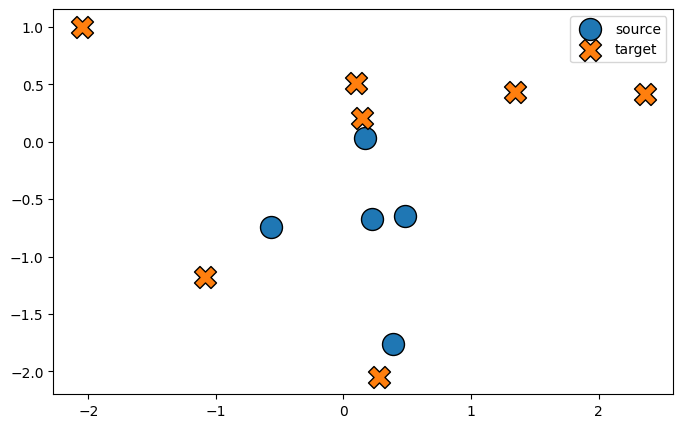

In [3]:
@dataclass
class Costs:
    sqeuclidean = ott.geometry.costs.SqEuclidean()
    
x_viz_kwargs = {"s": 250,"edgecolor": "k", "label": "source"}
y_viz_kwargs = {"s": 250, "marker": "X", "edgecolor": "k", "label": "target"}

def generate_random_clouds(rng, n, m, d):
    x_key, y_key, marginal_a_key, marginal_b_key = jax.random.split(rng, 4)
    x = jax.random.normal(key=x_key, shape=(n, d))
    y = jax.random.normal(key=y_key, shape=(m, d))

    a = jax.nn.softmax(jax.random.normal(key=marginal_a_key, shape=(n, ))) # normalization to make valid pdf
    b = jax.nn.softmax(jax.random.normal(key=marginal_b_key, shape=(m, )))
    return x, y, a, b

x, y, a, b = generate_random_clouds(jax.random.PRNGKey(42), n=5, m=7, d=2)

plt.figure(figsize=(8, 5))
plt.scatter(x[:, 0], x[:, 1], **x_viz_kwargs)
plt.scatter(y[:, 0], y[:, 1], **y_viz_kwargs)
plt.legend()

In [4]:
geom = ott.geometry.pointcloud.PointCloud(x, y, cost_fn=Costs.sqeuclidean)
#linear_problem = ott.problems.linear.linear_problem.LinearProblem(geom, a=a, b=b)
ot = jax.jit(ott.solvers.linear.solve, static_argnames=['progress_fn'])(geom, a=a, b=b, progress_fn=tqdm_progress_fn(tqdm.tqdm())) # since linear.solve implicitly constructs linear_problem object

  2%|█▌                                                                              | 4/200 [00:01<04:43,  1.45s/it, error: 9.396300e-05]

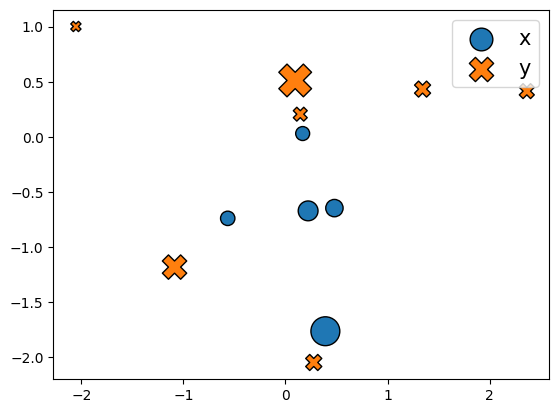

In [16]:
plott = ott.tools.plot.Plot(show_lines=False)
_ = plott(ot)

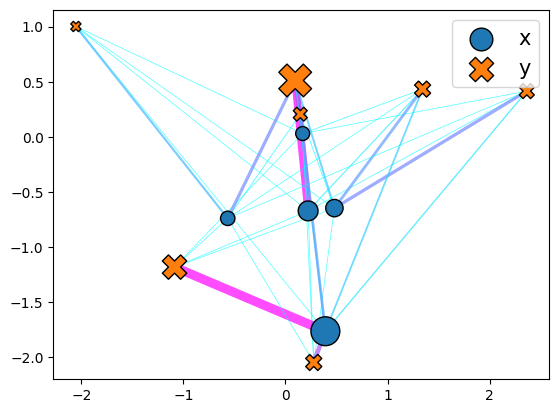

In [6]:
plott = ott.tools.plot.Plot(show_lines=True)
_ = plott(ot)

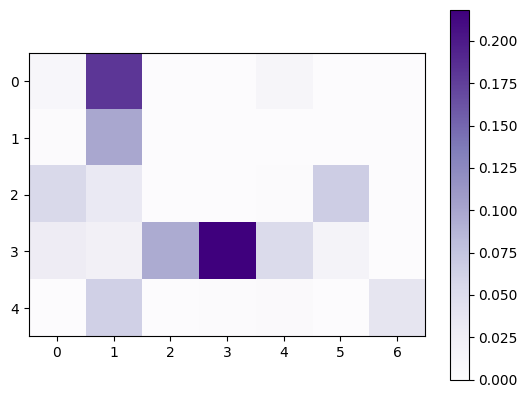

In [7]:
P = ot.matrix
plt.imshow(P, cmap="Purples")
plt.colorbar();

## Making differentiable

In [30]:
from IPython import display

def display_animation(ots, plot_class=ott.tools.plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, frame_rate=4)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

In [31]:
def optimize(
    x,
    y,
    a=None,
    b=None,
    num_iter: int = 100,
    dump_every: int = 10,
    learning_rate: float = 0.2,
    **kwargs
):
    def reg_ot_cost(geom, a, b):
        out = ott.tools.sinkhorn_divergence.sinkhorn_divergence(
            geom,
            a=a,
            b=b,
            x=geom.x,
            y=geom.y,
            static_b=True,
        )
        return out.divergence, out
    reg_ot_cost_vg = jax.jit(jax.value_and_grad(reg_ot_cost, has_aux=True, argnums=(0, 1)))
    
    ots = []
    for i in range(0, num_iter + 1):
        geom = ott.geometry.pointcloud.PointCloud(x, y, **kwargs)
        (reg_ot_cost, ot), (geom_g, grad_a) = reg_ot_cost_vg(geom, a, b)
        assert ot.converged
        x = x - geom_g.x * learning_rate
        a = jax.nn.softmax(a - grad_a * learning_rate)
        if i % dump_every == 0:
            ots.append(ot)
    return ots
ots = optimize(
        x,
        y,
        a=a,
        b=b,
        num_iter=200,
        epsilon=0.18,
        cost_fn=Costs.sqeuclidean,
    )
class CustomPlot(ott.tools.plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y
plot_ots(ots, plot_class=CustomPlot)

<Figure size 800x500 with 0 Axes>

In [40]:
ot = jax.jit(ott.solvers.linear.solve, static_argnames=['progress_fn'])(ots[0].geoms[0], a=ots[0].a, b=b, progress_fn=tqdm_progress_fn(tqdm.tqdm()))








0it [00:00, ?it/s]






0it [00:01, ?it/s, error: 3.720480e-01]






  0%|▍                                                                               | 1/200 [00:01<03:54,  1.18s/it, error: 3.720480e-01]






  0%|▍                                                                               | 1/200 [00:01<03:54,  1.18s/it, error: 2.135198e-01]






  1%|▊                                                                               | 2/200 [00:01<03:53,  1.18s/it, error: 2.267018e-02]






  2%|█▏                                                                              | 3/200 [00:01<03:51,  1.18s/it, error: 1.496438e-03]






  2%|█▌                                                                              | 4/200 [00:01<03:50,  1.18s/it, error: 9.396300e-05]

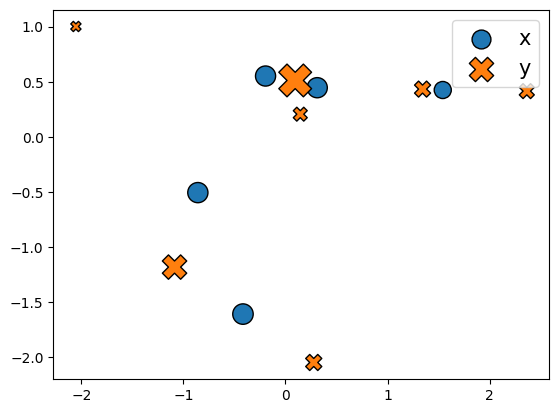

In [39]:
plott = ott.tools.plot.Plot(show_lines=False)
_ = plott(ot)

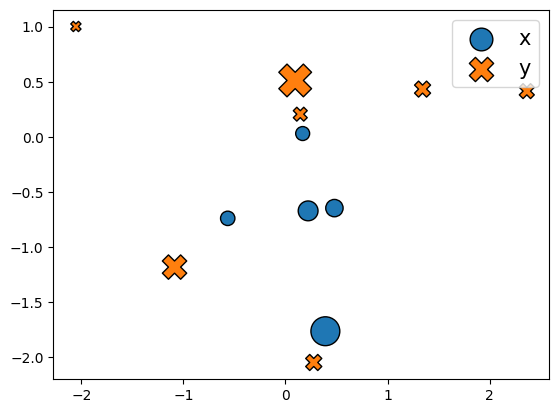

In [41]:
plott = ott.tools.plot.Plot(show_lines=False)
_ = plott(ot)